# Continous Control Project - Report

---

In this notebook, a solution to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) is provided. Specifically, a Deep Deterministic Policy Gradients is trained to play the Unity-Tennis game and maximize the reward score.

This jupyter notebook is designed to serve as report for the project, by providing all necessary details of the learning algorithm used.
At the same time, the notebook also serves as training/testing of the agent to play the game.

## Implementation

- A Deep Deterministic Policy Gradients (DDPG) learning algorithm is implemented using pytorch to perform the given task.

- The DDPG has 2 networks (local and target) for both actor and critic parts of the agent, making a 
    total of 4 networks. Each network has 2 fully connected layers (first of size `256` and second of
    size `128`) with ReLU activation function, where `input_size` is the number of states in the
    environment, here `8`. `output_size` is the number of actions possible for the agent; here `2`.
    The activation function for the last layer is tanh for the actor, to ensure output is limited to a
    magnitude of 1.
    ```
        ('fc1', nn.Linear(input_size, fc1_units))
        ('reLU', nn.ReLU())
        ('fc2', nn.Linear(fc1_units, fc2_units))
        ('reLU', nn.ReLU())
        ('fc3', nn.Linear(fc2_units, output_size))
        ('tanh', nn.tanh())
    ```

    The Q-network is tasked with the objective to find the optimal policy π* for the agent.
    ```
    Q(s,a) = Q(s, a) + α[R(s, a) + γmaxQ'(s',a')-Q(s,a)]
    ```
    
- [Ornstein–Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process):
    The OU process is used as a noise which helps the agent explore the new possible cases where
    the agent can improve itself by learning new samples with (potentially) higher rewards.

- Fixed target implementation: A double DQN approach is also adopted where the 2 sets of DQN
    are maintained by the agent i.e. local and target. The local network is the one trained at
    specific intervals. However, for evaluation of the agent's performance is based on the target
    network which slowly converges to local network. This approach ensures that the recently
    learned info by the local network doesn't disrupt the overall performance of the agent.
    Furthermore, the approach makes the network learn slowly but tends to converge to learn correct
    experiences over long periods.

- Soft update: To update the weights of the target network, a simple weighted average between
    the local and the target network is performed periodically. Depending on the weight, the
    target network undergoes a soft update with respect to the high-frequency varying local
    network.

- Hyperparameters: Several hyperparameters are used in the training/testing process, details
    of which are given below. Further, the specific values of the parameters used during
    the training session are stored in `log_path` file. Similarly, the graph of score vs episode
    is stored as `fig_path` file. Users are requested to examine these two files for the training
    performance.

## 1. Setup parameters (User-input required)

Tune the following parameters to obtain necessary results.

NOTE: Ensure `train_flag=False` and that `model_path` file is available in the current folder if an already trained model is to be tested.

In [1]:
# Training parameters
train_flag = False # Set True if wish to train a network, else set False for testing
SEED = 4 # Set user-defined seed to ensure same results, else set False for random seed

# Environment parameters
qualify_score = 0.5 # Score at which the training must stop
score_window = 100 # Number of episodes for which the qualify score should be maintained as average

# QNN parameters
ACTOR_FC = [256, 128] # Neurons in the hidden fully connected layers
CRITIC_FC = [256, 128] # Neurons in the hidden fully connected layers

ACTOR_LR = 1e-4 # Learning rate actor
CRITIC_LR = 1e-4 # Learning rate critic

WEIGHT_DECAY = 0 # L2 weight decay
BATCH_SIZE = 128 # Number of samples/batch for training the Q network

# DRL parameters
steps_max = 2**15 # Maximum number of steps to be taken in an episode
train_episodes = 2**15 # Number of episodes for which the agent must be trained

TAU = 1e-1 # The degree of influence the target network has on the main/local network
UPDATE_EVERY = 1 # Number of time-steps in an episode after which the Q network should be updated

BUFFER_SIZE = 2**20 # Number of episodes to keep in memory (experience replay)
GAMMA = 0.99 # Discount factor of the rewards

# OUNoise parameters
THETA = 0.15
SIGMA = 0.2

# Extra variables for ease of use
app_path = 'Tennis_Linux/Tennis.x86_64'
model_path = 'checkpoint.pth'

log_path = 'output.txt'
fig_path = 'output.pdf'

## 2. Import necessary libraries

In [2]:
# Environment
from unityagents import UnityEnvironment

# NN
import torch as tc
from torch import nn, optim
import torch.nn.functional as F

# Replay buffer
from collections import namedtuple, deque

# General
import copy
import random
import numpy as np
from time import sleep, time
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Setup the Unity environment

In [3]:
# Setup environment
env = UnityEnvironment(file_name=app_path)
device = tc.device("cpu")
# device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# get environment details
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print('Using {} agents.'.format(num_agents))
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Using 2 agents.


## 4. Build Deep Q-Network

The following class builds generic NN models for actor and critic with only FC layers and ReLU activation function (using `pytorch`), except tanh activation for last layer of actor because values need to be clipped in \[-1,1\].
The size and number of hidden layers are tunable.

In [4]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor_Network(nn.Module):
    """Actor Model."""

    def __init__(self, state_size, output_size, seed=False, fc1_units=256, fc2_units=128):
        """
        Build a simple Fully Connected neural network with n hidden layers and ReLU activation.

        Param
        =====
            state_size (int): Dimension of input layer
            output_size (int): Dimension of output layer
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        
        super(Actor_Network, self).__init__()
        
        if seed:
            self.seed = tc.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return tc.tanh(self.fc3(x))



class Critic_Network(nn.Module):
    """Critic Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """
        Build a simple Fully Connected neural network with n hidden layers and ReLU activation.

        Param
        =====
            state_size (int): Dimension of state layer
            action_size (int): Dimension of action layer
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        
        super(Critic_Network, self).__init__()
        
        if seed:
            self.seed = tc.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = tc.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 5. Ornstein–Uhlenbeck Process Noise
OU Process is a Gauss–Markov process and over time, the process tends to drift towards its long-term mean.
This is useful for generating Gaussian noise about the state of a dynamic which tends towards the mean value.

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## 6. Create a Replay Buffer

Experience replay is a key technique behind many recent advances in deep reinforcement learning.
Allowing the agent to learn from earlier memories can speed up learning and break undesirable temporal correlations.
A replay buffer stores all the past memories upto `buffer_size` length.

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed=False):
        """
        Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.batch_size = batch_size
        
        
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", \
                                     field_names=["state", "action", "reward", "next_state", "done"])
        
        if seed:
            self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        if self.batch_size < len(self.memory):
            experiences = random.sample(self.memory, k=self.batch_size)
        else:
            experiences = random.sample(self.memory, k=len(self.memory))

        states = tc.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = tc.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = tc.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = tc.from_numpy(np.vstack([e.next_state for e in experiences if e is not None]\
                                             )).float().to(device)
        dones = tc.from_numpy(np.vstack([e.done for e in experiences if e is not None]\
                                       ).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## 6. Create Agent

Create an agent to play the game and learn from it.
Notice that the agent uses both of the above defined classes to create required objects.

In [7]:
class Agent():
    """
    Interacts with and learns from the environment.
    
    Global Params used:
    ------------------
    SEED
    ACTOR_FC
    CRITIC_FC
    ACTOR_LR
    CRITIC_LR
    BUFFER_SIZE
    BATCH_SIZE
    UPDATE_EVERY
    GAMMA
    TAU
    
    Global Class used:
    ------------------
    DQN
    ReplayBuffer
    """

    def __init__(self, state_size, action_size):
        """
        Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        
        self.state_size = state_size
        self.action_size = action_size
        if SEED:
            self.seed = np.random.seed(SEED)

        # Actor Network
        self.actor_local = Actor_Network(state_size, action_size, SEED, ACTOR_FC[0], ACTOR_FC[1]).to(device)
        self.actor_target = Actor_Network(state_size, action_size, SEED, ACTOR_FC[0], ACTOR_FC[1]).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=ACTOR_LR)
        
        # Critic Network
        self.critic_local = Critic_Network(state_size, action_size, SEED, CRITIC_FC[0], \
                                           CRITIC_FC[1]).to(device)
        self.critic_target = Critic_Network(state_size, action_size, SEED, CRITIC_FC[0], \
                                            CRITIC_FC[1]).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=CRITIC_LR, \
                                           weight_decay=WEIGHT_DECAY)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, SEED)
        
        # Noise process
        self.noise = OUNoise((num_agents, action_size), SEED, 0., THETA, SIGMA)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, states, actions, rewards, next_states, dones):
        
        # Separate experiences from different "agents" into a lot of experiences from same agent
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if (self.t_step == 0) and (len(self.memory) > UPDATE_EVERY):
            self.learn()

    def act(self, state, add_noise=True):
        """
        Returns actions for given state as per current policy.
        """
        state = tc.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with tc.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self):
        """
        Update value parameters using given batch of experience tuples.
        """
        states, actions, rewards, next_states, dones = self.memory.sample()
        
        # 1. Critic local optimize
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 2. Actor local optimize
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 3. Critic and action target update
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)
        
    def soft_update(self, local_model, target_model):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

## 7: Train the network (only if `train_flag=True`)

NOTE: Training results are stored as `log_path` and the graph as `fig_path` files.

	 Episode: 100 Step: 030 Score: 0.05  
Episode: 100 Avg Time: 0.23s Avg Score: 0.00
	 Episode: 200 Step: 069 Score: 0.15  
Episode: 200 Avg Time: 0.31s Avg Score: 0.05
	 Episode: 300 Step: 013 Score: -0.00  
Episode: 300 Avg Time: 0.36s Avg Score: 0.08
	 Episode: 400 Step: 012 Score: -0.00  
Episode: 400 Avg Time: 0.41s Avg Score: 0.10
	 Episode: 500 Step: 052 Score: 0.10  
Episode: 500 Avg Time: 0.46s Avg Score: 0.10
	 Episode: 600 Step: 069 Score: 0.15  
Episode: 600 Avg Time: 0.50s Avg Score: 0.11
	 Episode: 700 Step: 040 Score: 0.05  
Episode: 700 Avg Time: 0.57s Avg Score: 0.16
	 Episode: 800 Step: 070 Score: 0.10  
Episode: 800 Avg Time: 0.70s Avg Score: 0.25
	 Episode: 900 Step: 037 Score: 0.05  
Episode: 900 Avg Time: 0.86s Avg Score: 0.33
	 Episode: 1000 Step: 013 Score: -0.00  
Episode: 1000 Avg Time: 1.05s Avg Score: 0.42
Solved environment in 1189 episodes, avg score: 0.50


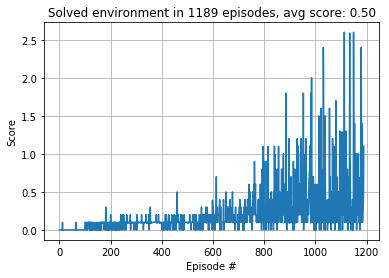

In [8]:
# Create an agent which interacts with the environment
agent = Agent(state_size, action_size)

if train_flag:

    # Setup variables
    all_scores = []
    steps_period = int(steps_max/10)
    episode_period = min([int(train_episodes/100), score_window])
    start_time = time()

    # Log info (such that browser can be safely closed)
    text = 'train_flag = {}\nSEED = {}\nqualify_score = {}\nscore_window = {}\nACTOR_FC = {}\n' + \
           'CRITIC_FC = {}\nACTOR_LR = {}\nCRITIC_LR = {}\nBATCH_SIZE = {}\nsteps_max = {}\n' + \
           'train_episodes = {}\nTAU = {}\nUPDATE_EVERY = {}\nBUFFER_SIZE = {}\nGAMMA = {}\n\n'
    text = text.format(train_flag, SEED, qualify_score, score_window, ACTOR_FC, CRITIC_FC, ACTOR_LR, \
                       CRITIC_LR, BATCH_SIZE, steps_max, train_episodes, TAU, UPDATE_EVERY, \
                       BUFFER_SIZE, GAMMA)
    with open(log_path,'w+') as file:
        file.write(text)

    for e in range(train_episodes):

        # Reset environment and setup variables
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations # get the current state (for each agent)
        scores = np.zeros(num_agents) # initialize the score (for each agent)
        solved_flag = False

        for t in range(steps_max):
            # Get next action from the agent
            actions = agent.act(states)
            actions = np.clip(actions, -1, 1)              # all actions between -1 and 1

            # Run one step and collect env info
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished
            scores += rewards

            # Check if required average score is obtained
            if t % steps_period == 0:
                text = "\t Episode: {} Step: {:03} Score: {:0.2f}  ".format(e, t, np.mean(scores))
                print(text, end = '\r')
                with open(log_path,'a+') as file:
                    file.write(text+'\n')

            # Prepare for the next step
            agent.step(states, actions, rewards, next_states, dones) # Store the information of last step
            states = next_states # Update states
            
            if any(dones):
                    break

        # Check if required average score is obtained
        text = "\t Episode: {} Step: {:03} Score: {:0.2f}  ".format(e, t, np.mean(scores))
        print(text, end = '\r')
        with open(log_path,'a+') as file:
            file.write(text+'\n')

        # Check if required average score is obtained
        all_scores.append(np.max(scores))
        if len(all_scores) > score_window:
            if e % episode_period == 0:
                text = "Episode: {} Avg Time: {:0.2f}s Avg Score: {:0.2f}".format(e, (time()-start_time)/e, \
                                                                            np.mean(all_scores[-score_window:]))
                with open(log_path,'a+') as file:
                    file.write(text+'\n')

                print()
                print(text)
                
                # Plot the scores - for better viz, than just texts
                fig = plt.figure()
                plt.plot(np.arange(len(all_scores)), all_scores)
                plt.ylabel('Score')
                plt.xlabel('Episode #')
                plt.grid()
                fig.savefig(fig_path, bbox_inches='tight') # Vector graphics for detailed viz
                plt.close(fig)
                
            if np.mean(all_scores[-score_window:]) > qualify_score:
                text = "Solved environment in {} episodes, avg score: {:0.2f}".format(\
                    e, np.mean(all_scores[-score_window:]))

                with open(log_path,'a+') as file:
                    file.write(text+'\n')
                
                print(text)
                
                tc.save(agent.actor_local.state_dict(), str(num_agents) + '_actor_' + model_path)
                tc.save(agent.critic_local.state_dict(), str(num_agents) + '_critic_' + model_path)
                
                solved_flag = True
                
                break
        
    # Plot the scores
    fig = plt.figure()
    plt.plot(np.arange(len(all_scores)), all_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    if solved_flag:
        plt.title(text)
    else:
        plt.title(text[2:])
    plt.grid()
    plt.show()
    fig.savefig(fig_path, bbox_inches='tight') # Vector graphics for detailed viz
    fig.savefig('rewards.png', bbox_inches='tight') # Raster graphics to show later in Section 9
    plt.close(fig)

## 8: Test the performance (only if `train_flag=False`)

Test an already trained agent.

In [9]:
if not train_flag:
    
    # Initialization
    agent.actor_local.load_state_dict(tc.load(str(num_agents)+'_actor_'+model_path)) # load the weights from file
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = env_info.vector_observations # get the current state (for each agent)
    scores = np.zeros(num_agents) # initialize the score (for each agent)

    while True:
        actions = agent.act(states) # select an action (for each agent)
        env_info = env.step(actions)[brain_name] # send the action to the environment
        scores += env_info.rewards # get the reward (for each agent)
        dones = env_info.local_done # see if episode has finished (for each agent)
        if np.any(dones): # exit loop if episode finished (for any agent)
            break
        next_states = env_info.vector_observations # get the next state (for each agent)
        states = next_states # roll over the state to next time step (for each agent)

    print('Total score (averaged over agents) in this episode: {}'.format(np.mean(scores)))

In [10]:
# Close environment
env.close()

## 9. Conclusion

### Plot of training rewards

![tennis_agent_rewards](rewards.png)

NOTE: The above figure might not be the true figure due to disk cache problem. Please see `fig_path` file for the latest and true graph.

### Observations

- Fortunately for me, this is a direct implementation of the [previous project](https://github.com/saurabverma/DRL_cont_ctrl), thus not much updates were required to solve this project. Although, a tremendous amount of hardwork was implemented in the previous project.
- My main plan was to implement 'intuitive learning' as in the user can provide a few episodes of good samples and thereafter, the agent can improve its performance even though rewards are very sparse.
- One particular thing noted is that the agent performance is still low, but a few peak scores (around 2.5) brought the whole average of score to 0.5.

### Future Ideas

Especially for continuous action-space, a lot of novel algorithms are being developed such as SAC, A3C, A2C, PPO, Rainbow, etc. Therefore, it would be worth trying such algorithms, or a mixture of them to potentially improve the agent's performance. Furthermore, thanks to Unity and other developers, we should explore several environments (apart from double joint limb) as testbeds for the aforementioned algorithms.

In practice, more than the DRL algorithm, many other factors play significant role in agent's performance such as the state space reqresentation, reward function, good sample experiences from an expert, evolution theories to tune the parameters, etc. Thus, a DRL agent as such must be designed with the whole complete system in mind and not just the DRL algorithm. Such explorations will be examined in future.